# Collocated RCE analysis

## Imports and Warnings

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import random
import scipy 
from dask.distributed import Client, progress, wait

import warnings
warnings.filterwarnings(action='ignore')

## Opening Data

In [3]:
path = '/pf/b/b381607/RCE_WORK/RCE_DATA_CLUSTERED/'
ssts = np.arange(280,315,5)

mean_280 = xr.open_dataset(path+'RCE_COL_MEAN_280.nc')
mean_285 = xr.open_dataset(path+'RCE_COL_MEAN_285.nc')
mean_290 = xr.open_dataset(path+'RCE_COL_MEAN_290.nc')
mean_295 = xr.open_dataset(path+'RCE_COL_MEAN_295.nc')
mean_300 = xr.open_dataset(path+'RCE_COL_MEAN_300.nc')
mean_305 = xr.open_dataset(path+'RCE_COL_MEAN_305.nc')
mean_310 = xr.open_dataset(path+'RCE_COL_MEAN_310.nc')

max_280 = xr.open_dataset(path+'RCE_COL_MAX_280.nc')
max_285 = xr.open_dataset(path+'RCE_COL_MAX_285.nc')
max_290 = xr.open_dataset(path+'RCE_COL_MAX_290.nc')
max_295 = xr.open_dataset(path+'RCE_COL_MAX_295.nc')
max_300 = xr.open_dataset(path+'RCE_COL_MAX_300.nc')
max_305 = xr.open_dataset(path+'RCE_COL_MAX_305.nc')
max_310 = xr.open_dataset(path+'RCE_COL_MAX_310.nc')

means = [mean_280,mean_285,mean_290,mean_295,mean_300,mean_305,mean_310]
maxes = [max_280,max_285,max_290,max_295,max_300,max_305,max_310]

data_mean = xr.combine_nested(means,concat_dim='clusters')
data_max = xr.combine_nested(maxes,concat_dim='clusters')

## Functions

In [4]:
def nan_array(shape):
    
    an_array = np.empty(shape)

    an_array[:] = np.NaN
    
    return an_array

def maxk_arg(matrix,k):
    #returns indices of max k elements in a matrix
    
    matrix_new = matrix.flatten()
    
    matrix_arg = np.argsort(matrix_new)
    
    return matrix_arg[-k:]

def bin_stat_function(n_bins,lower,upper,x_variable,y_variable,threshold=0,pc1=95,pc2=99.99,n_max=5):
    #Creates a range of bin values within which the data should lie, collects indices of x-variables
    #which fall in those bins and calls the corresponding y-variable values, calculates means
    #and percentiles. 
    
    #n_bins = number of bins, lower and upper = bounds of bins, threshold is a required number
    #of values to have if statistics are to be calculated, pc1,2 are percentiles, assumed 95 and 99
    
    cc = np.linspace(lower,upper,n_bins)
    
    #nan filled arrays created
    
    x_bins = nan_array((n_bins,1))
    y_bins = nan_array((n_bins,1))
    
    y_bins_pc1 = nan_array((n_bins,1))
    y_bins_pc2 = nan_array((n_bins,1))
    
    x_max = nan_array((n_bins,n_max))
    y_max = nan_array((n_bins,n_max))
    
    x_bins_error = nan_array((n_bins,1))
    y_bins_error = nan_array((n_bins,1))
    
    
    #reduced bin values for the loop below
    cc_red = cc[:-1]
    
    for i,value in enumerate(cc_red):
        
        #indices of values within bins
        j = np.where((x_variable >= value) & (x_variable < cc[i+1]))

        x_vals = x_variable[j]
        y_vals = y_variable[j]

        #threshold inspected    
        if len(j[0]) > threshold:
            
            #mean of x values within bin
            x_bins[i] = np.nanmean(x_vals)
            x_bins_error[i] = np.nanstd(x_vals)   
            
            #mean and percentiles of associated y variable
            y_bins[i] = np.nanmean(y_vals)
            y_bins_error[i] = np.nanstd(y_vals)
    
            y_bins_pc1[i] = np.nanpercentile(y_vals,pc1)
            y_bins_pc2[i] = np.nanpercentile(y_vals,pc2)

            if len(j[0]) >= n_max:
        
                j = maxk_arg(y_vals,n_max)

            
                x_max[i] = x_vals[j]
            
                y_max[i] = y_vals[j]
    

    return x_bins,y_bins,y_bins_pc1,y_bins_pc2,x_bins_error,y_bins_error,x_max,y_max

def sst_binning(n_bins,suptitle,var_names,var_units,x_arrays,y_arrays,threshold_val=5,n_max_val=1,z_level=False,z_var='y'):
    
    fig,axes = plt.subplots(2,3,figsize=(20,15))
    fig.suptitle(suptitle,x=0.515,y=0.925,fontsize=15)

    for i,ax in enumerate(axes.flat):
            
        if z_level != False:
            
            if z_var == 'y':
                
                x_bins,y_mean,y_pc1,y_pc2,x_err,y_err,x_max,y_max = bin_stat_function(n_bins,min(x_arrays[i][var_names[0]].values),max(x_arrays[i][var_names[0]].values),
                                                                                      x_arrays[i][var_names[0]].values,y_arrays[i][var_names[1]].isel(z=z_level).values,threshold=threshold_val
                                                                                      ,n_max=n_max_val)
            else:
                
                x_bins,y_mean,y_pc1,y_pc2,x_err,y_err,x_max,y_max = bin_stat_function(n_bins,min(x_arrays[i][var_names[0]].isel(z=z_level).values),max(x_arrays[i][var_names[0]].isel(z=z_level).values),
                                                                                      x_arrays[i][var_names[0]].isel(z=z_level).values,y_arrays[i][var_names[1]].values,threshold=threshold_val
                                                                                      ,n_max=n_max_val)
                
        else:
            x_bins,y_mean,y_pc1,y_pc2,x_err,y_err,x_max,y_max = bin_stat_function(n_bins,min(x_arrays[i][var_names[0]].values),max(x_arrays[i][var_names[0]].values),
                                                                                  x_arrays[i][var_names[0]].values,y_arrays[i][var_names[1]].values,threshold=threshold_val
                                                                                  ,n_max=n_max_val)
    
        ax.errorbar(x_bins,y_mean,yerr=y_err.flatten(),xerr=x_err.flatten(),color='k',ls='none',label='Mean')
        ax.scatter(x_bins,y_pc1,color='orange',label='95th Percentile')
        #ax.scatter(x_bins,y_pc2,color='yellow')
        ax.scatter(x_max,y_max,color='red',label='Max')
        
       # print(var_names[0],var_)
    
        ax.set(title='SST:'+str(ssts[:-1][i])+'$K$',
               xlabel=var_names[0] + var_units[0],
               ylabel=var_names[1] + var_units[1])
        
    plt.legend()
    plt.show()
        
    return

def ssts_scatter_plot(x_arrs,y_arrs,title,var_names,var_units,z_level=False,z_var='y'):

    fig,ax = plt.subplots(figsize = (14,10))
    ax.set_title(title)
    ax.set(xlabel=var_names[0]+var_units[0],ylabel=var_names[1]+var_units[1])
    
    for i,x_arr in enumerate(x_arrs[::-1]):

        #plt.scatter(mean.CAPE.values,mean.SD.values,label=ssts[::-1][i])
        if z_level != False:
            
            if z_var == 'y':
                plt.scatter(x_arr[var_names[0]].values,y_arrs[::-1][i][var_names[1]].isel(z=z_level).values,label='SST:' + str(ssts[::-1][i]) + '$K$')
            
            else:
                
                plt.scatter(x_arr[var_names[0]].isel(z=z_level).values,y_arrs[::-1][i][var_names[1]].values,label='SST:' + str(ssts[::-1][i]) + '$K$')
                
     
        else:   
        
            plt.scatter(x_arr[var_names[0]].values,y_arrs[::-1][i][var_names[1]].values,label='SST:' + str(ssts[::-1][i]) + '$K$')
        
    plt.legend()

    plt.show()
    
    return

## Graphing

### Precipitation Intensity vs CWVC

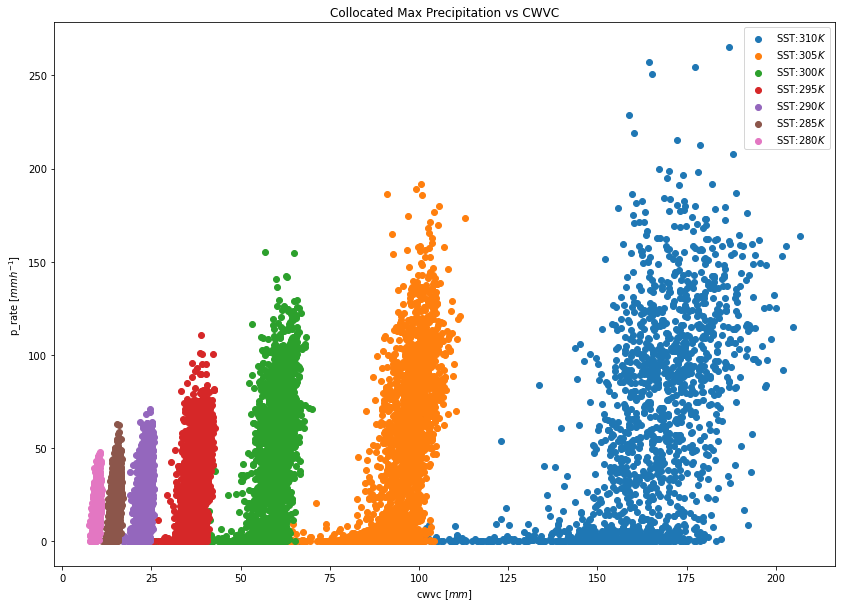

In [5]:
"""
fig,ax = plt.subplots(figsize=(18,13))
ax.set_title('Collocated Max precipitation Intensity vs CWVC',fontsize=20)
ax.set_xlabel('CWVC [$mm$]', fontsize= 15)
ax.set_ylabel('Precipitation Intensity [$mm h^{-1}$]',fontsize= 15)

for i,data in enumerate(maxes):
    
    ax.scatter(means[i].cwvc,data.p_rate,label='SST:'+str(ssts[i])+' $K$')
    
plt.legend(loc='best')

#space between plots adjusted
plt.subplots_adjust(wspace=.25, hspace=0.45)

plt.show()
"""
ssts_scatter_plot(means,maxes,'Collocated Max Precipitation vs CWVC',['cwvc','p_rate'],[' [$mm$]',' [$mm h^{-1}$]'])

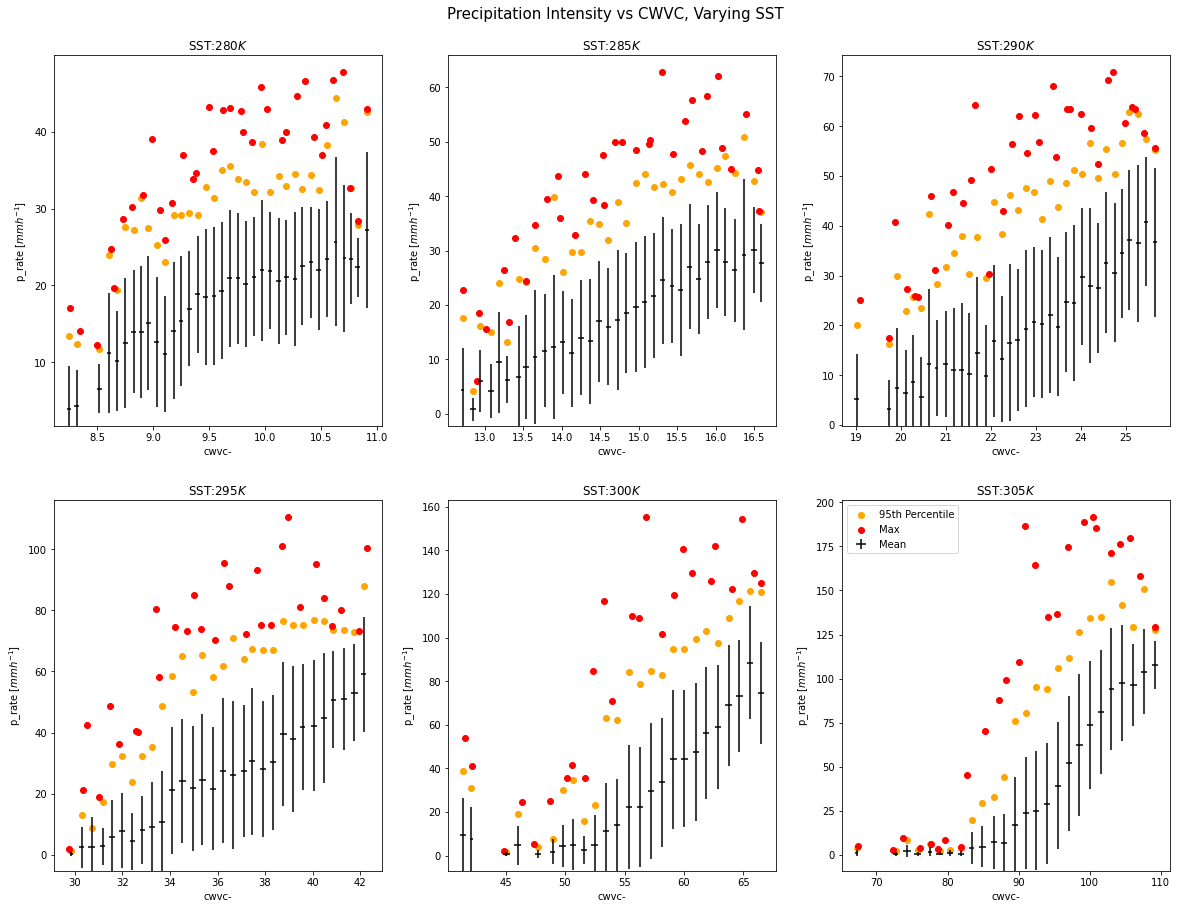

In [6]:
sst_binning(50,'Precipitation Intensity vs CWVC, Varying SST',['cwvc','p_rate'],['-',' [$mm h^{-1}$]'],means,maxes,threshold_val=5)

### Precipitation Intensity vs CAPE


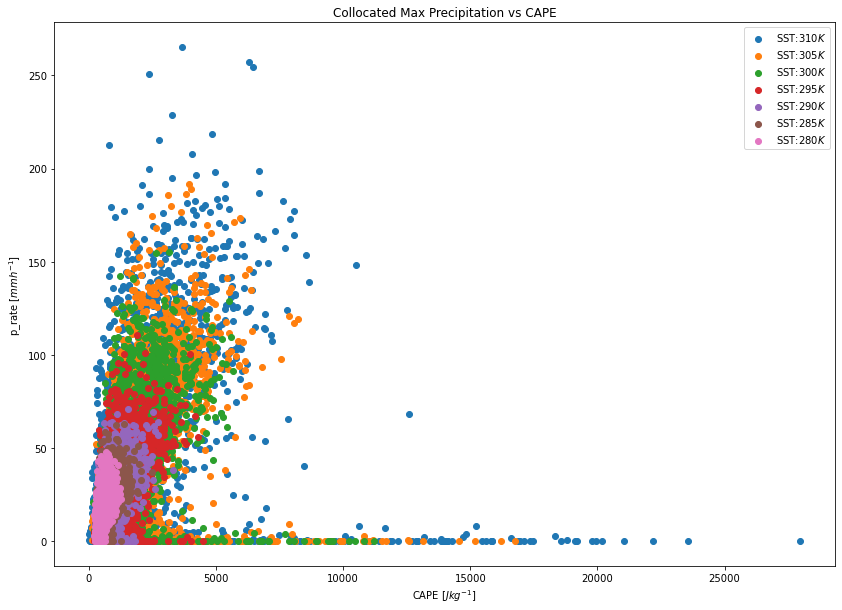

In [7]:
"""
fig,ax = plt.subplots(figsize=(14,10))
ax.set_title('Max Precipitation Intensity vs CAPE',fontsize=15)
ax.set(xlabel='CAPE [$J kg^{-1}$]',ylabel='Precipitation Intensity [$mm h^{-1}$]')
for i,data in enumerate(maxes[::-1]):
    
    ax.scatter(means[::-1][i].CAPE,data.p_rate,label='SST:'+str(ssts[::-1][i])+' $K$')

plt.legend()
plt.show()
"""

ssts_scatter_plot(means,maxes,'Collocated Max Precipitation vs CAPE',['CAPE','p_rate'],[' [$J kg^{-1}$]',' [$mm h^{-1}$]'])

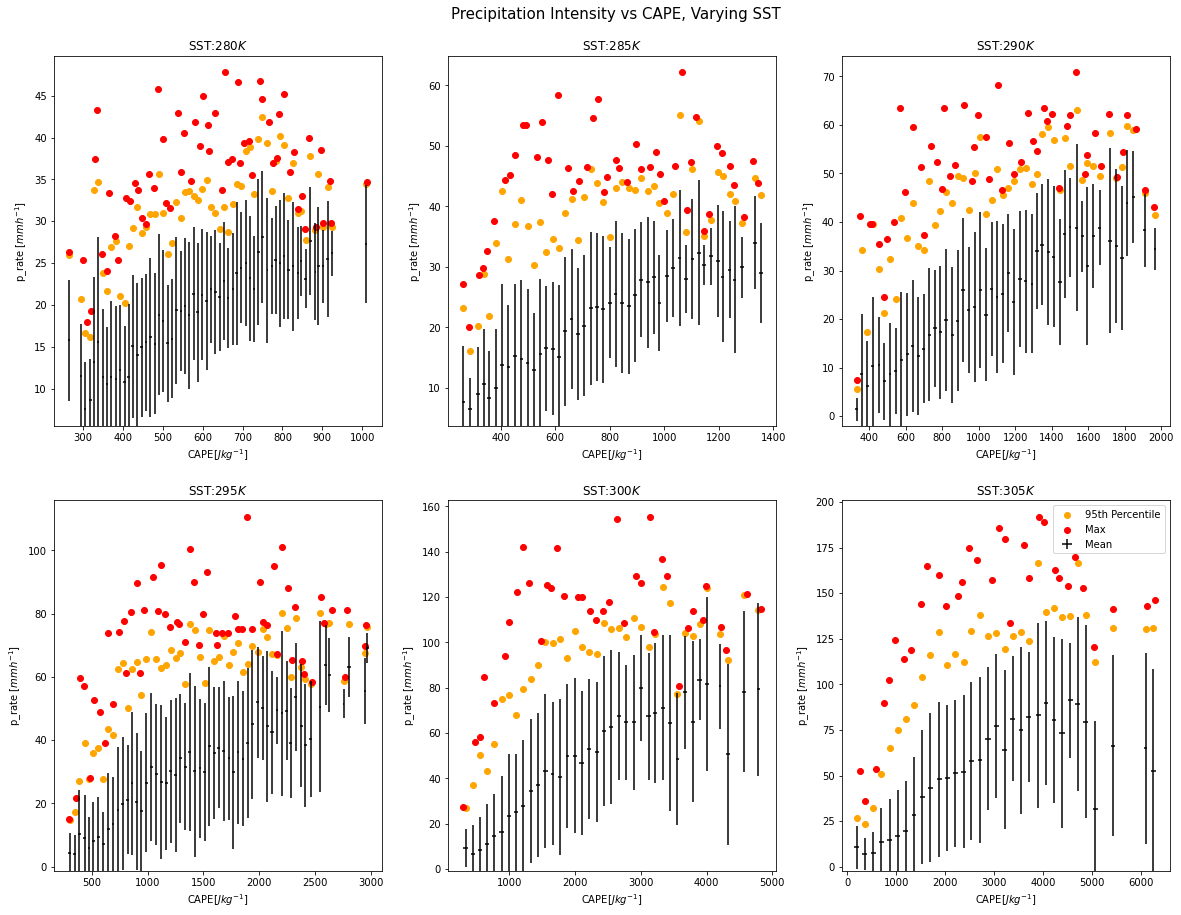

In [8]:
sst_binning(100,'Precipitation Intensity vs CAPE, Varying SST',['CAPE','p_rate'],['[$J kg^{-1}$]',' [$mm h^{-1}$]'],means,maxes,threshold_val=5)

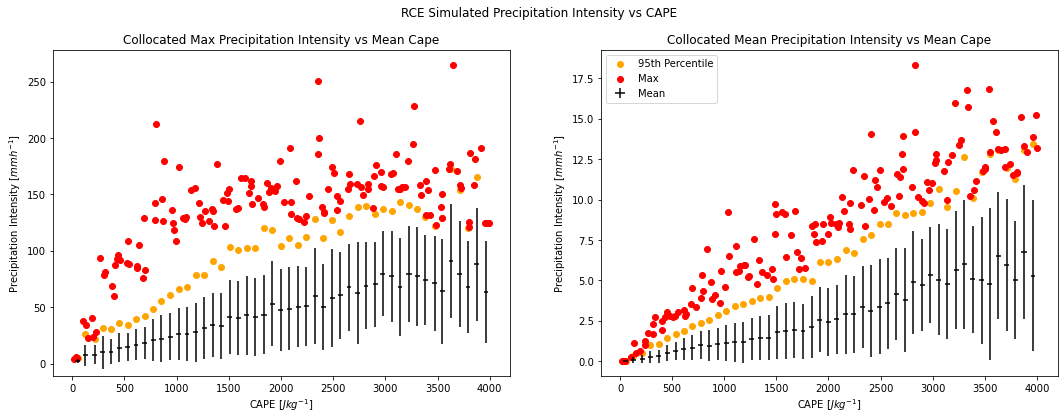

In [9]:
def cape_precip_plot(bins,lower,upper,threshold_val=10,n_max_val=3):

    cape_bins_pmax,pmax_mean,pmax_pc1,pmax_pc2,cape_err_pmax,pmax_err,cape_max_pmax,pmax_max = bin_stat_function(bins,lower,upper,data_mean.CAPE.values,data_max.p_rate.values,threshold=threshold_val,n_max=n_max_val)

    cape_bins_pmean,pmean_mean,pmean_pc1,pmean_pc2,cape_err_pmean,pmean_err,cape_max_pmean,pmean_max = bin_stat_function(bins,lower,upper,data_mean.CAPE.values,data_mean.p_rate.values,threshold=threshold_val,n_max=n_max_val)

    #max(data_mean.CAPE.values)

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,6))
    fig.suptitle('RCE Simulated Precipitation Intensity vs CAPE')

    ax1.set(title='Collocated Max Precipitation Intensity vs Mean Cape',
            xlabel='CAPE [$J kg^{-1}$]',ylabel='Precipitation Intensity [$mm h^{-1}$]')

    ax1.errorbar(cape_bins_pmax,pmax_mean,yerr=pmax_err.flatten(),xerr=cape_err_pmax.flatten(),color='k',ls='none')
    ax1.scatter(cape_bins_pmax,pmax_pc1,color='orange')
    #ax1.scatter(cape_bins,pmax_pc2,color='yellow')
    ax1.scatter(cape_max_pmax,pmax_max,color='red')

    ax2.set(title='Collocated Mean Precipitation Intensity vs Mean Cape',
            xlabel='CAPE [$J kg^{-1}$]',ylabel='Precipitation Intensity [$mm h^{-1}$]')


    ax2.errorbar(cape_bins_pmean,pmean_mean,yerr=pmean_err.flatten(),xerr=cape_err_pmean.flatten(),color='k',ls='none',label='Mean')
    ax2.scatter(cape_bins_pmean,pmean_pc1,color='orange',label='95th Percentile')
    #ax2.scatter(cape_bins,pmean_pc2,color='yellow')
    ax2.scatter(cape_max_pmean,pmean_max,color='red',label='Max')
    
    plt.legend()

    plt.show()
    
    return 

cape_precip_plot(50,0,4000)

- p vs cape
-p vs cvwc --- maybe fit exponentials , check ssts individually
-  cape vs sd

- omega vs cape

### CAPE vs Saturation Deficit

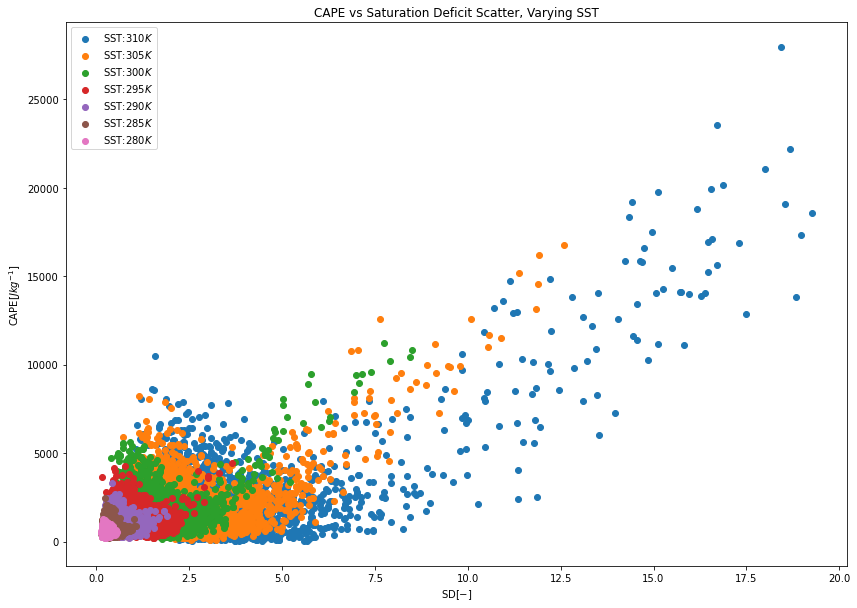

In [10]:
ssts_scatter_plot(means,means,'CAPE vs Saturation Deficit Scatter, Varying SST',['SD','CAPE'],['[$-$]','[$J kg^{-1}$]'])

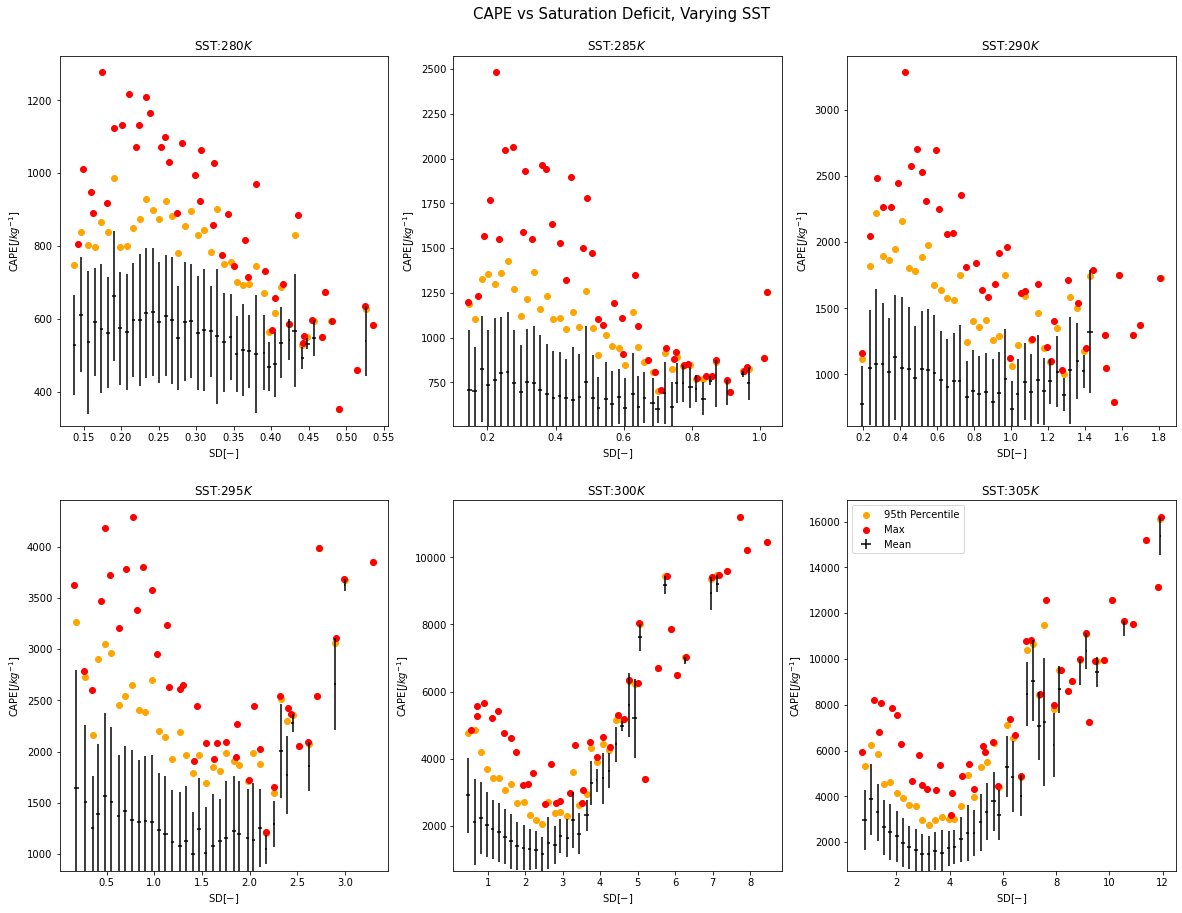

In [11]:
sst_binning(50,'CAPE vs Saturation Deficit, Varying SST',['SD','CAPE'],['[$-$]','[$J kg^{-1}$]'],means,means,n_max_val=1,threshold_val=0)

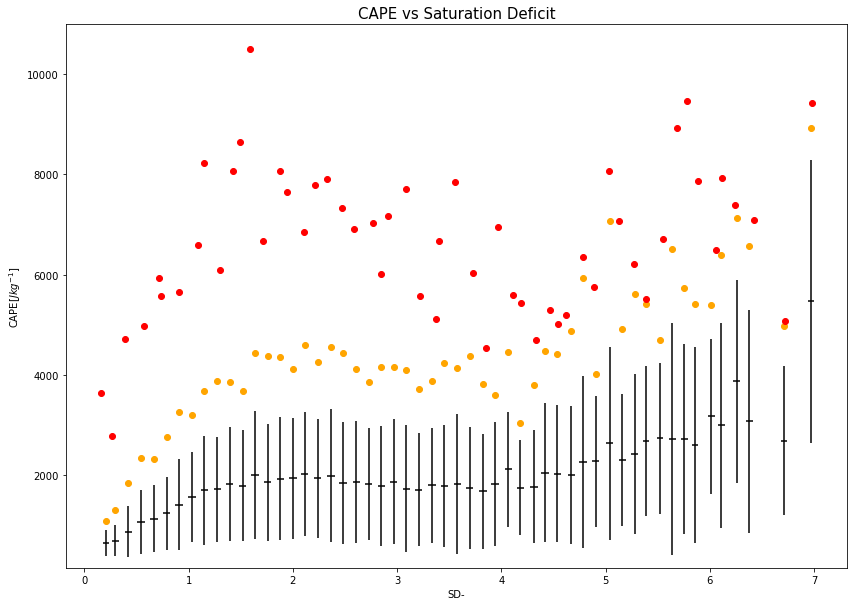

In [12]:
def general_binning(x_var,y_var,n_bins,lower,upper,title,var_names,var_units,threshold_val=0,pc1_val=95,pc2_val=99.99,n_max_val=3):

    fig,ax = plt.subplots(figsize = (14,10))
    
    ax.set_title(title,fontsize=15)
    ax.set(xlabel = var_names[0]+var_units[0],ylabel=var_names[1]+var_units[1])
    
    x_bins,y_mean,y_pc1,y_pc2,x_err,y_err,x_max,y_max = bin_stat_function(n_bins,lower,upper,x_var,y_var,threshold=threshold_val,n_max=n_max_val)
    
    ax.errorbar(x_bins,y_mean,yerr=y_err.flatten(),xerr=x_err.flatten(),color='k',ls='none')
    ax.scatter(x_bins,y_pc1,color='orange')
    ax.scatter(x_max,y_max,color='red')
    
    plt.show()
    
general_binning(data_mean.SD.values,data_mean.CAPE.values,100,0,12,'CAPE vs Saturation Deficit',['SD','CAPE'],['-','[$J kg^{-1}$]'],threshold_val=10,n_max_val=1)

### Pressure Velocity vs CAPE

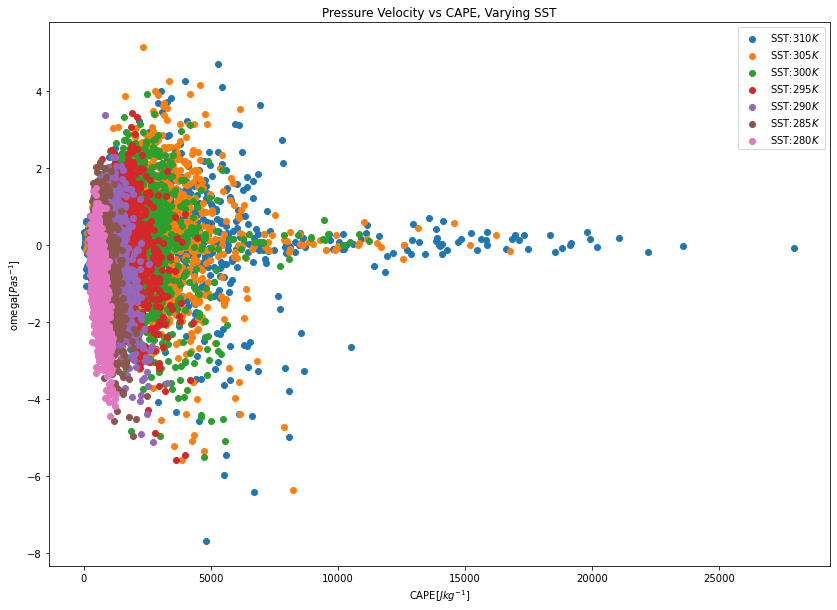

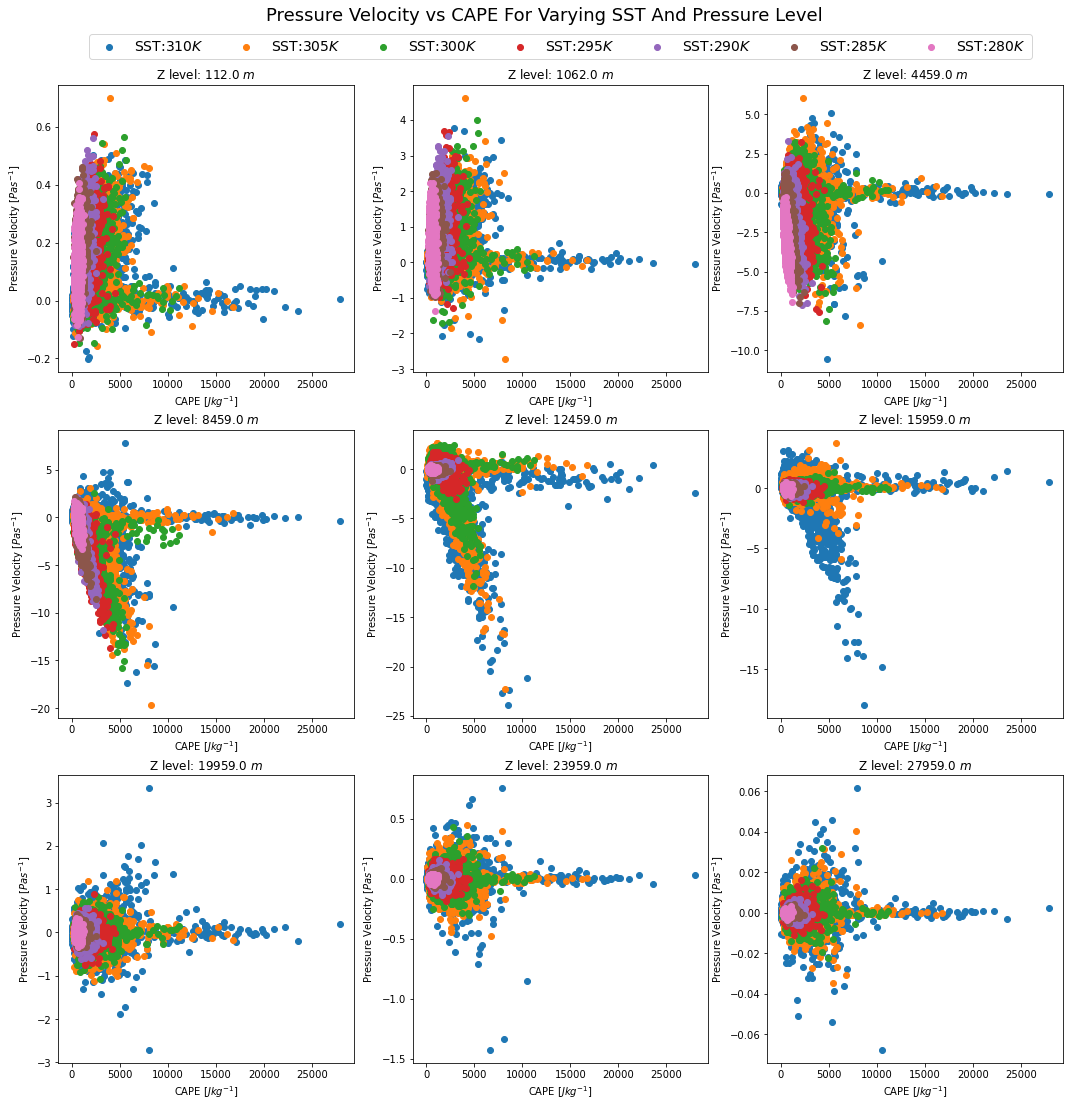

In [13]:
ssts_scatter_plot(means,means,'Pressure Velocity vs CAPE, Varying SST',['CAPE','omega'],['[$J kg^{-1}$]','[$Pa s^{-1}$]'],z_level=14)

def omega_cape_zplots():
    
    fig,axes = plt.subplots(3,3,figsize=(18,18))
    fig.suptitle('Pressure Velocity vs CAPE For Varying SST And Pressure Level',y=0.94,fontsize=18)

    z_is = np.linspace(1,63,9,dtype=int)
    
    for i,ax in enumerate(axes.flat):
        
        ax.set(xlabel='CAPE [$J kg^{-1}$]',ylabel='Pressure Velocity [$ Pa s^{-1}$]')
        ax.set_title('Z level: {} $m$'.format(str(means[0].z.values[z_is[i]])))
        
        for k,mean in enumerate(means[::-1]):
            ax.scatter(mean.CAPE.values,mean.omega.isel(z=z_is[i]).values,label='SST:' + str(ssts[::-1][k]) + '$K$')
        
    plt.legend(loc='upper center',bbox_to_anchor=(-0.7,3.6),ncol=7,fontsize=14)
    plt.show()
    
    return

omega_cape_zplots()
 

## CAPE VS PRESSURE VELOCITY, z level 31 and 14

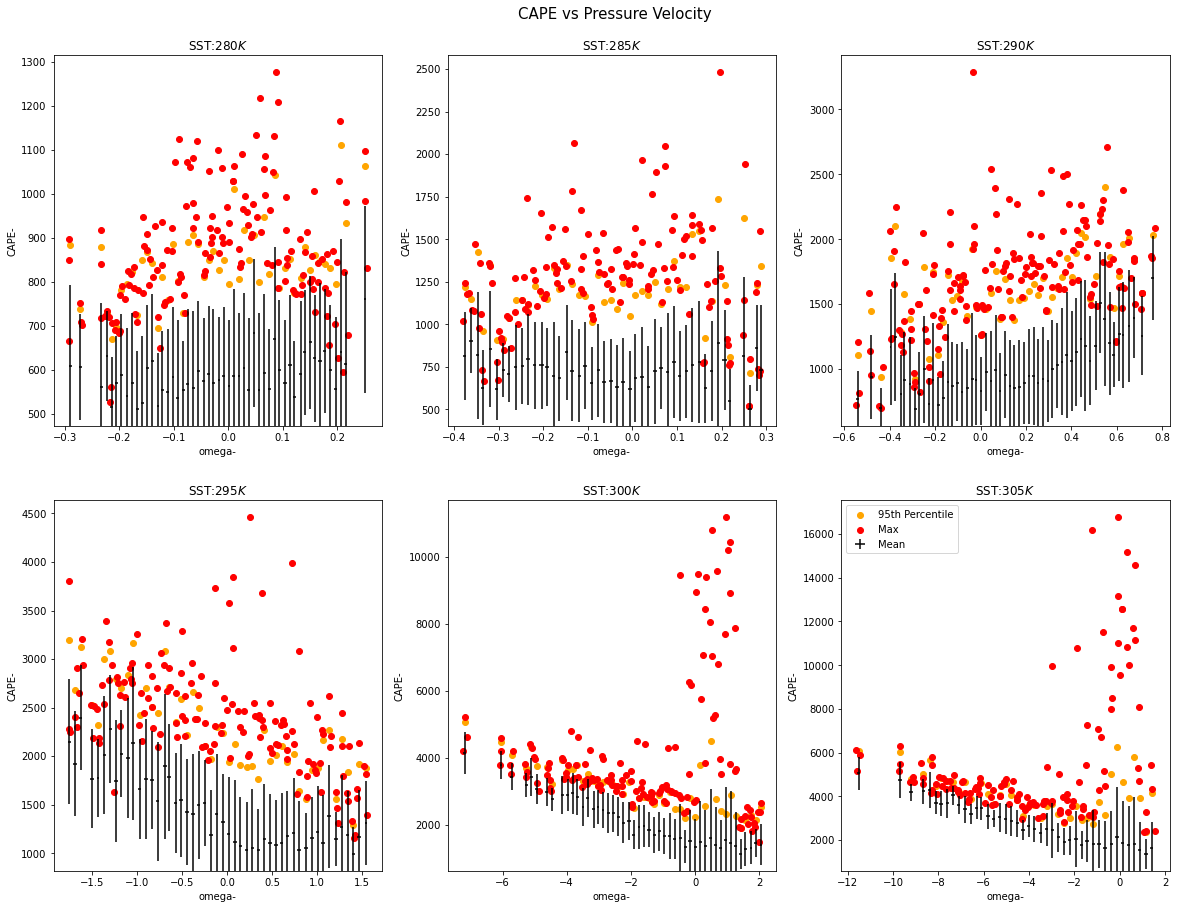

In [29]:
sst_binning(100,'CAPE vs Pressure Velocity',['omega','CAPE'],['-','-'],means,means,z_level=31,z_var='x',n_max_val=3)


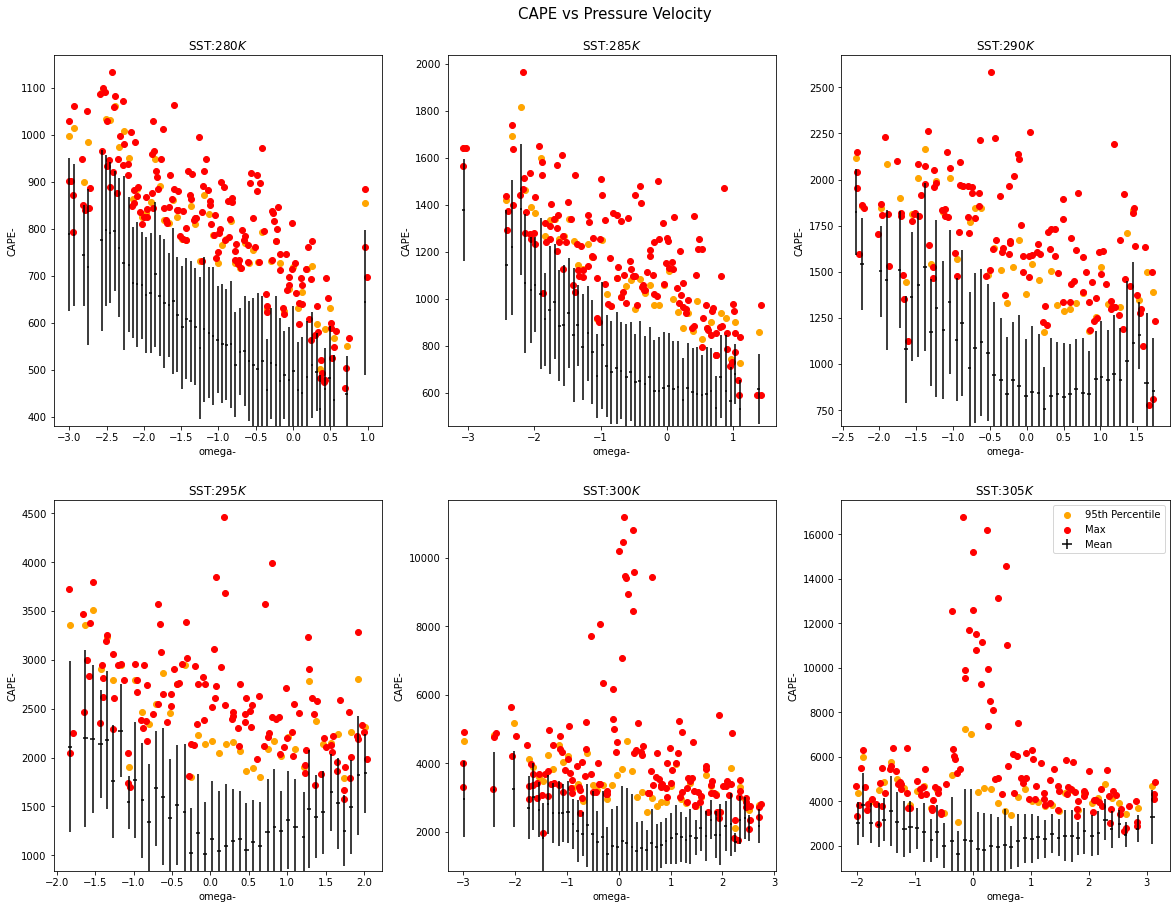

In [32]:
sst_binning(100,'CAPE vs Pressure Velocity',['omega','CAPE'],['-','-'],means,means,z_level=14,z_var='x',n_max_val=3)


### PRESSURE VELOCITY VS CAPE, Z LEVELS 31 and 14

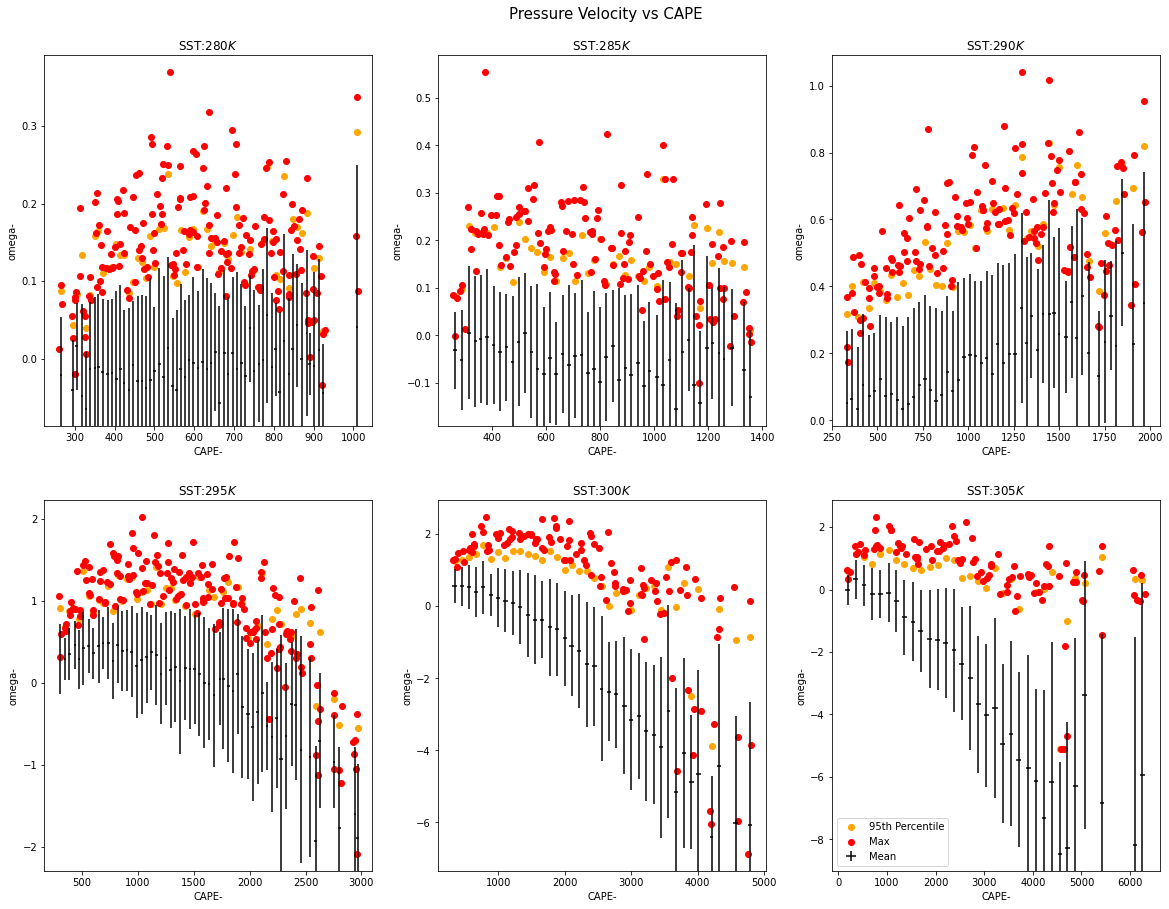

In [33]:
sst_binning(100,'Pressure Velocity vs CAPE',['CAPE','omega'],['-','-'],means,means,z_level=31,z_var='y',n_max_val=3)


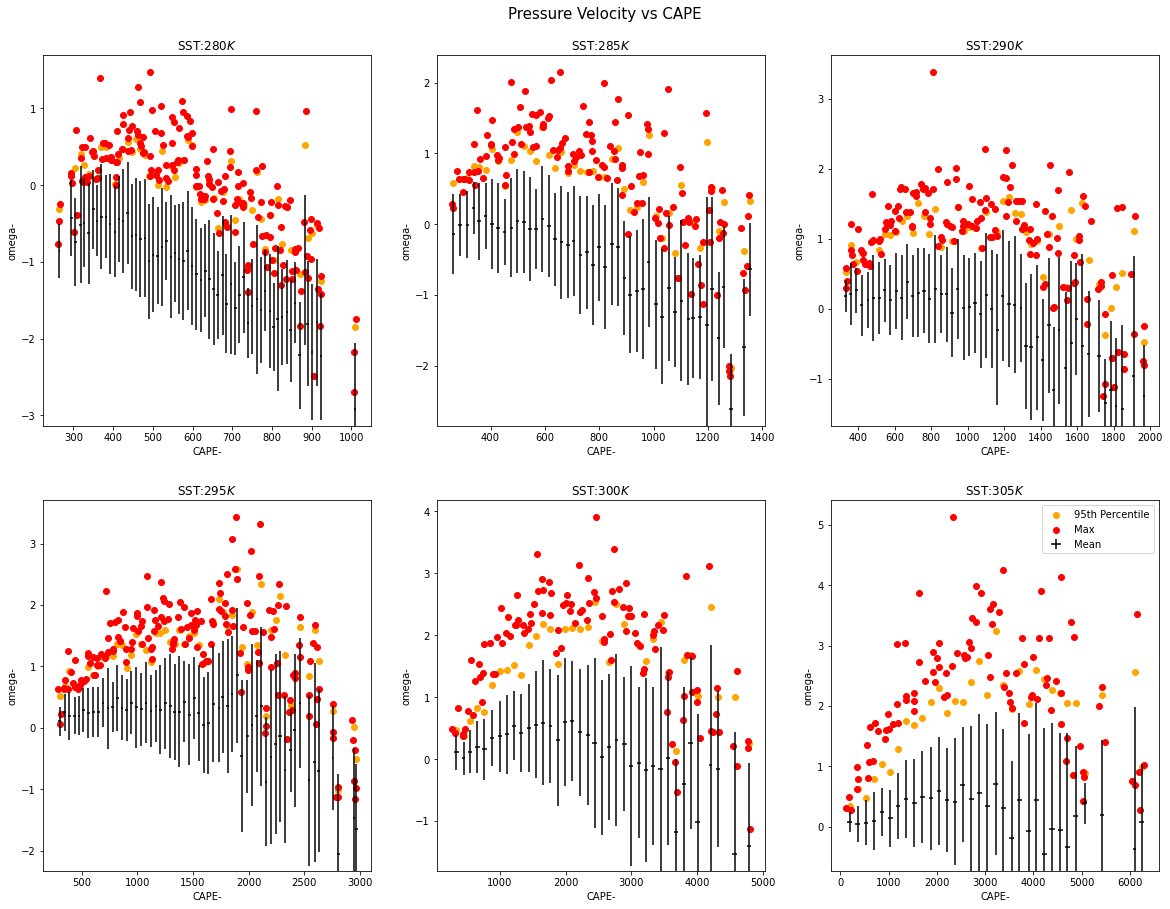

In [34]:
sst_binning(100,'Pressure Velocity vs CAPE',['CAPE','omega'],['-','-'],means,means,z_level=14,z_var='y',n_max_val=3)


## Precipitation Intensity vs Pressure Velocity
## Z levels 63,47, 31,15 and 1

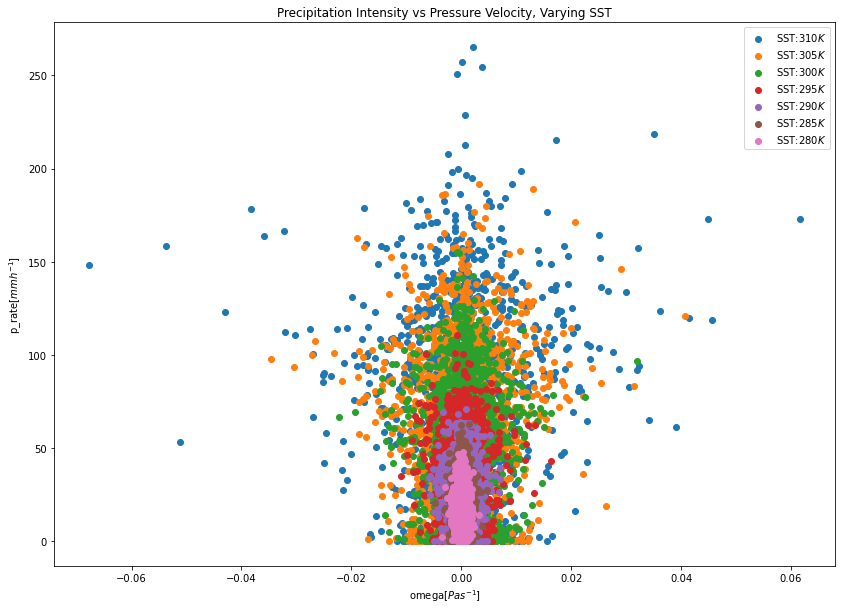

In [53]:
ssts_scatter_plot(means,maxes,'Precipitation Intensity vs Pressure Velocity, Varying SST',['omega','p_rate'],['[$Pa s^{-1}$]','[$mm h^{-1}$]'],z_level=63,z_var='x')

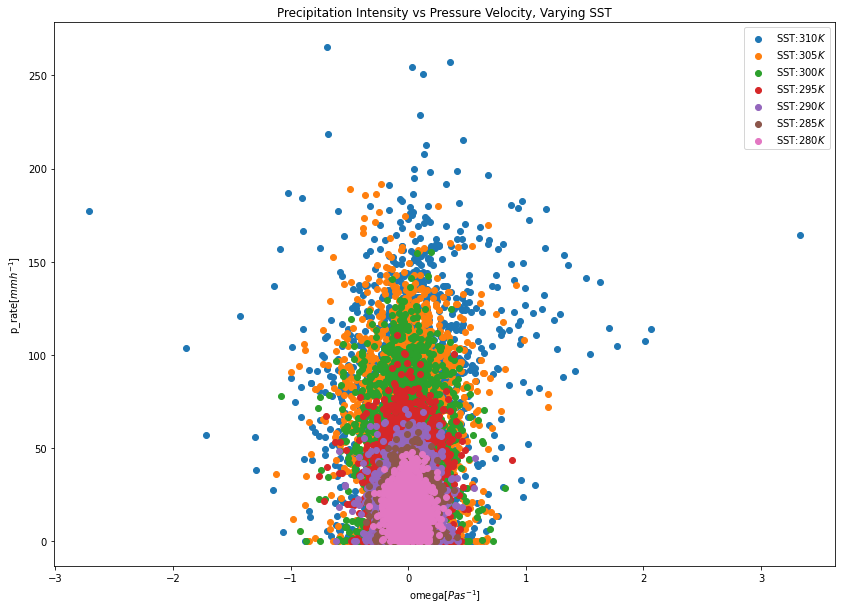

In [54]:
ssts_scatter_plot(means,maxes,'Precipitation Intensity vs Pressure Velocity, Varying SST',['omega','p_rate'],['[$Pa s^{-1}$]','[$mm h^{-1}$]'],z_level=47,z_var='x')

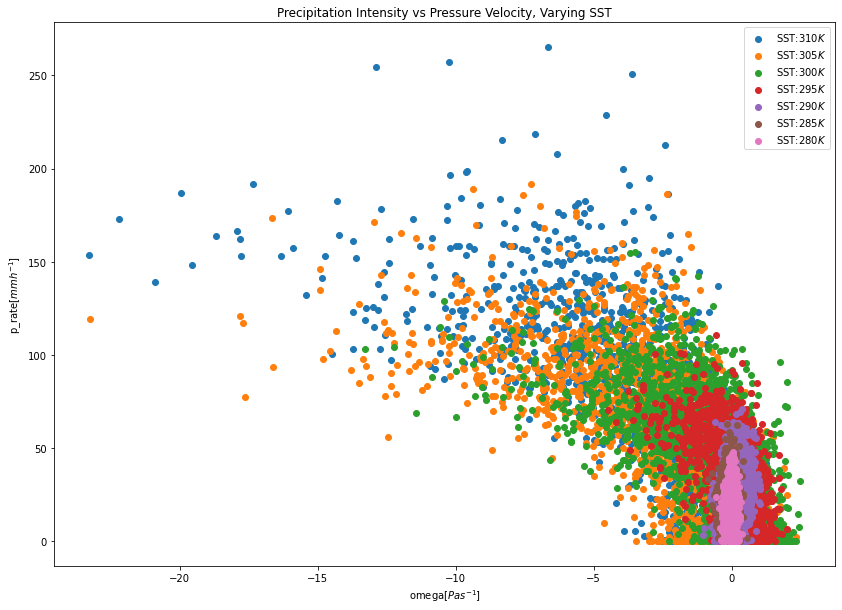

In [55]:
ssts_scatter_plot(means,maxes,'Precipitation Intensity vs Pressure Velocity, Varying SST',['omega','p_rate'],['[$Pa s^{-1}$]','[$mm h^{-1}$]'],z_level=31,z_var='x')

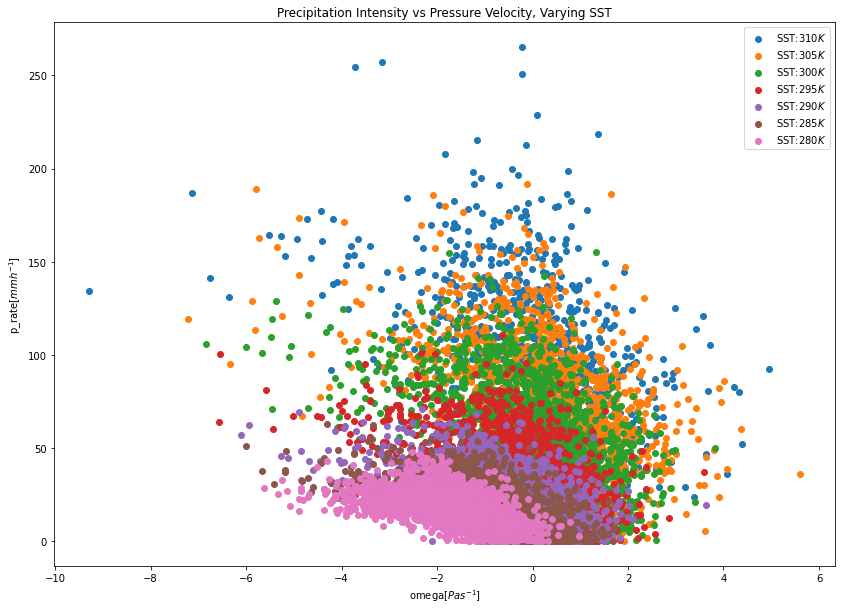

In [56]:
ssts_scatter_plot(means,maxes,'Precipitation Intensity vs Pressure Velocity, Varying SST',['omega','p_rate'],['[$Pa s^{-1}$]','[$mm h^{-1}$]'],z_level=15,z_var='x')

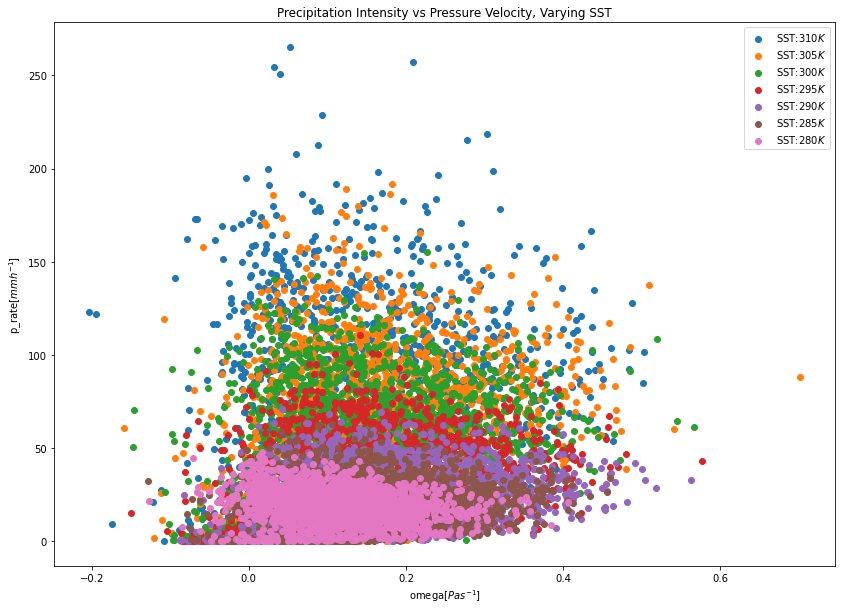

In [57]:
ssts_scatter_plot(means,maxes,'Precipitation Intensity vs Pressure Velocity, Varying SST',['omega','p_rate'],['[$Pa s^{-1}$]','[$mm h^{-1}$]'],z_level=1,z_var='x')

title
3 slides to introduce problem, mechanism schematic: cape-SD, cape-precipitation 
- slide 1. mcs scale is difficult
- 2 not easy to determine how environment of mcs clouds causes extreme precipitation
- 3 mechanism schematic
2 slides to introduce data
- ERA, reanalysis, interpolation
- RCE, show collocated storm channel 
storm identification
- criteria
- Implementation
precipitation vs cwvc relationship, baselines check
- slide 8: era p-cwvc
- slide 9, rce sst stratification
